<a href="https://colab.research.google.com/github/sayandas96476/gemstone-identification-using-deep-learning-approach/blob/main/Custom_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [ ]:
!unzip -u /content/drive/MyDrive/test.zip -d /content
!unzip -u /content/drive/MyDrive/train.zip -d /content

Archive:  /content/drive/MyDrive/test.zip
   creating: /content/test/Alexandrite/
  inflating: /content/test/Alexandrite/alexandrite_18.jpg  
  inflating: /content/test/Alexandrite/alexandrite_28.jpg  
  inflating: /content/test/Alexandrite/alexandrite_3.jpg  
  inflating: /content/test/Alexandrite/alexandrite_6.jpg  
   creating: /content/test/Almandine/
  inflating: /content/test/Almandine/almandine_18.jpg  
  inflating: /content/test/Almandine/almandine_28.jpg  
  inflating: /content/test/Almandine/almandine_3.jpg  
  inflating: /content/test/Almandine/almandine_9.jpg  
   creating: /content/test/Amazonite/
  inflating: /content/test/Amazonite/amazonite_18.jpg  
  inflating: /content/test/Amazonite/amazonite_28.jpg  
  inflating: /content/test/Amazonite/amazonite_3.jpg  
  inflating: /content/test/Amazonite/amazonite_8.jpg  
   creating: /content/test/Amber/
  inflating: /content/test/Amber/amber_18.jpg  
  inflating: /content/test/Amber/amber_28.jpg  
  inflating: /content/test/Amb

In [ ]:
train_path = '/content/train'
test_path = '/content/test'
BATCH_SIZE = 64
IMG_SIZE = 224 #for vgg-16/19
seed=123
input_shape = (IMG_SIZE,IMG_SIZE)
# Training ImagaDataGenerator with Augmentation transf.  
train_datagen = ImageDataGenerator(rescale=1./255,\
                                   rotation_range=15, shear_range=10,\
                                   zoom_range=0.1, fill_mode='nearest', \
                                   height_shift_range=0.05, width_shift_range=0.1)


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(directory=test_path,
                                            target_size = (224, 224),
                                            color_mode='rgb',
                                            class_mode = 'categorical',
                                            interpolation='nearest')

Found 363 images belonging to 87 classes.


In [ ]:
import tensorflow as tf

In [ ]:
def Resblock2D_v2(x, kernel_size, out_filters, strides, dilation_rate, elu_alpha, name):
    fx = tf.keras.layers.BatchNormalization(name=name+'bn1')(x)
    fx = tf.keras.layers.ELU(alpha=elu_alpha, name=name+'act1')(fx)
    fx = tf.keras.layers.Conv2D(out_filters, kernel_size, strides=strides, padding='same', dilation_rate=dilation_rate, name=name+'conv2')(fx)
    fx = tf.keras.layers.BatchNormalization(name=name+'bn2')(fx)
    fx = tf.keras.layers.ELU(alpha=elu_alpha, name=name+'act2')(fx)
    fx = tf.keras.layers.Conv2D(out_filters, kernel_size, strides=strides, padding='same', dilation_rate=dilation_rate, name=name+'conv3')(fx)
    out = tf.keras.layers.Add(name=name+'add')([x,fx])
    return out

def Resblock1D_v2(x, n_units, elu_alpha, name):
    fx = tf.keras.layers.BatchNormalization(name=name+'bn1')(x)
    fx = tf.keras.layers.ELU(alpha=elu_alpha, name=name+'act1')(fx)
    fx = tf.keras.layers.Dense(n_units, name=name+'dense2')(fx)
    fx = tf.keras.layers.BatchNormalization(name=name+'bn2')(fx)
    fx = tf.keras.layers.ELU(alpha=elu_alpha, name=name+'act2')(fx)
    fx = tf.keras.layers.Dense(n_units, name=name+'dense3')(fx)
    out = tf.keras.layers.Add(name=name+'add')([x,fx])
    return out

def Custom_model(input_shape, n_calsses, elu_alpha):
    
    input_layer = tf.keras.layers.Input(shape=input_shape, name='input_layer')
    
    # increase dim
    x = tf.keras.layers.Conv2D(32, (3,3), strides=(2,2), padding='valid', input_shape=input_shape, name='block1_conv1')(input_layer)
    # resblock
    x = Resblock2D_v2(x, kernel_size=(3,3), out_filters=32, strides=(1,1), dilation_rate=(1,1), elu_alpha=elu_alpha, name='block1_')
    
    filters = [64, 128, 256]
    for block_num, n_filters in enumerate(filters, 2):
        # pre bn and act
        block_name = 'block'+str(block_num)+'_'
        x = tf.keras.layers.BatchNormalization(name=block_name+'pre_bn')(x)
        x = tf.keras.layers.ELU(alpha=elu_alpha, name=block_name+'pre_act')(x)
        # decrease img size
        x = tf.keras.layers.MaxPooling2D((2,2), strides=(2,2), name=block_name+'maxpool')(x)
        # increase dim
        x = tf.keras.layers.Conv2D(n_filters, (3,3), padding='same', input_shape=input_shape, name=block_name+'conv1')(x)
        # resblock
        x = Resblock2D_v2(x, kernel_size=(3,3), out_filters=n_filters, strides=(1,1), dilation_rate=(1,1), elu_alpha=elu_alpha, name=block_name)

    # Prediction layers
    #x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.BatchNormalization(name='pre_global_avg_pool_bn')(x)
    x = tf.keras.layers.ELU(alpha=elu_alpha, name='pre_global_avg_pool_act')(x)
    x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    #x = tf.keras.layers.Flatten()(x)
    
    # Dense layer
    block_num += 1
    block_name = 'block'+str(block_num)+'_'
    x = tf.keras.layers.Dense(256, name=block_name+'dense1')(x)
    # Residual block
    x = Resblock1D_v2(x, n_units=256, elu_alpha=elu_alpha, name=block_name)
    
    # Output layer
    x = tf.keras.layers.BatchNormalization(name='pre_output_bn')(x)
    x = tf.keras.layers.ELU(alpha=elu_alpha, name='pre_output_act')(x)
    x = tf.keras.layers.Dense(n_calsses)(x)
    
    return tf.keras.Model(inputs=input_layer, outputs=x, name='Custom_model')

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
import os
dict1={"image":[],"label":[]}
for label in os.listdir(train_path):
    for image in os.listdir(train_path+"/"+label):
        dict1["image"].append(label+"/"+image)
        dict1["label"].append(label)
temp_df = pd.DataFrame(dict1)
#print(pd.DataFrame(dict1))

In [ ]:
temp_df.set_index("image")

,label
image,
Grossular/grossular_5.jpg,Grossular
Grossular/grossular_4.jpg,Grossular
Grossular/grossular_25.jpg,Grossular
Grossular/grossular_17.jpg,Grossular
Grossular/grossular_19.jpg,Grossular
...,...
Andalusite/andalusite_34.jpg,Andalusite
Andalusite/andalusite_26.jpg,Andalusite
Andalusite/andalusite_16.jpg,Andalusite


In [ ]:
Y = temp_df[['label']]
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)  

In [ ]:
def get_model_name(k):#different model for each fold
    return 'model_'+str(k)+'.h5'

In [ ]:
from keras.metrics import TopKCategoricalAccuracy

In [ ]:
save_dir = '/content/drive/MyDrive/CustomResNet/saved_models/'#save model at this location

In [ ]:
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 
models_index_list=[]
for train_index, val_index in skf.split(np.zeros(2856),Y):
    models_index_list.append((train_index,val_index)) # Here we store information of each of the fold splits
#ideally we could have done entire training in this loop but it is time consuming.

In [ ]:
VALIDATION_ACCURACY = {}
VALIDATION_LOSS = {}

In [ ]:
#we change the value between 0 to 4 for each fold 

def train_model(fold_var):
    train_index, val_index = models_index_list[fold_var]
    training_data = temp_df.iloc[train_index]
    validation_data = temp_df.iloc[val_index]
    train_data_generator = train_datagen.flow_from_dataframe(training_data, directory = train_path,
						       x_col = "image", y_col = "label",batch_size=64,color_mode='rgb',
						       class_mode = "categorical", shuffle = True,interpolation='nearest')
    valid_data_generator  = train_datagen.flow_from_dataframe(validation_data, directory = train_path,
							batch_size=64,x_col = "image", y_col = "label",color_mode='rgb',
							class_mode = "categorical", shuffle = True,interpolation='nearest')
	# CREATE NEW MODEL
    model = Custom_model(list(input_shape)+[3],87, 1.0)
	# COMPILE NEW MODEL
    model.compile(
     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
     optimizer='adam',
    metrics=['accuracy',TopKCategoricalAccuracy(3, "top-3 accuracy"), TopKCategoricalAccuracy(5, "top-5 accuracy")])
    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
    earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',\
        min_delta=0, \
        patience=30, \
        verbose=0,\
        mode='min')
    history_cb = tf.keras.callbacks.CSVLogger("/content/drive/MyDrive/CustomResNet/log_"+get_model_name(fold_var)+".csv", separator=",", append=False)
    callbacks_list = [checkpoint,earlystopping_cb,history_cb]
	   # FIT THE MODEL
    history = model.fit(train_data_generator,
			    epochs=125,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator)
	   #PLOT HISTORY
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss'] 
    val_loss = history.history['val_loss'] #epochs_range = range(epochs) 
    plt.figure(figsize=(16, 4)) 
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy') 
    plt.plot(val_acc, label='Validation Accuracy') 
    plt.legend(loc='lower right') 
    plt.title('Training and Validation Accuracy') 
    plt.subplot(1, 2, 2) 
    plt.plot(loss, label='Training Loss') 
    plt.plot(val_loss, label='Validation Loss') 
    plt.legend(loc='upper right') 
    plt.title('Training and Validation Loss') 
    plt.show()	
    # LOAD BEST MODEL to evaluate the performance of the model 
    model.load_weights(save_dir+get_model_name(fold_var))
    results = model.evaluate(valid_data_generator)
    tf.keras.backend.clear_session()	

Found 2284 validated image filenames belonging to 87 classes.
Found 572 validated image filenames belonging to 87 classes.
Epoch 1/125
36/36 [==============================] - ETA: 0s - loss: 3.4372 - accuracy: 0.1511 - top-3 accuracy: 0.3183 - top-5 accuracy: 0.4299
Epoch 1: val_accuracy improved from -inf to 0.01399, saving model to /content/drive/MyDrive/CustomResNet/saved_models/model_0.h5
36/36 [==============================] - 53s 1s/step - loss: 3.4372 - accuracy: 0.1511 - top-3 accuracy: 0.3183 - top-5 accuracy: 0.4299 - val_loss: 15.1259 - val_accuracy: 0.0140 - val_top-3 accuracy: 0.0612 - val_top-5 accuracy: 0.0997
Epoch 2/125
36/36 [==============================] - ETA: 0s - loss: 2.5553 - accuracy: 0.3056 - top-3 accuracy: 0.5556 - top-5 accuracy: 0.6874
Epoch 2: val_accuracy improved from 0.01399 to 0.03846, saving model to /content/drive/MyDrive/CustomResNet/saved_models/model_0.h5
36/36 [==============================] - 40s 1s/step - loss: 2.5553 - accuracy: 0.3056 -

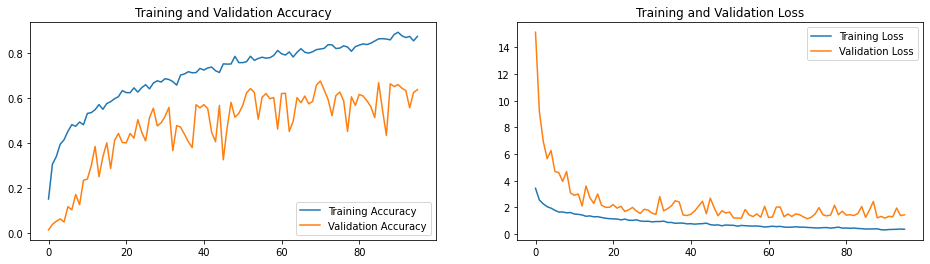

9/9 [==============================] - 8s 885ms/step - loss: 1.1396 - accuracy: 0.6696 - top-3 accuracy: 0.8881 - top-5 accuracy: 0.9545


In [ ]:
train_model(0)

Found 2285 validated image filenames belonging to 87 classes.
Found 571 validated image filenames belonging to 87 classes.
Epoch 1/125
36/36 [==============================] - ETA: 0s - loss: 3.4259 - accuracy: 0.1575 - top-3 accuracy: 0.3365 - top-5 accuracy: 0.4407
Epoch 1: val_accuracy improved from -inf to 0.01751, saving model to /content/drive/MyDrive/CustomResNet/saved_models/model_1.h5
36/36 [==============================] - 43s 1s/step - loss: 3.4259 - accuracy: 0.1575 - top-3 accuracy: 0.3365 - top-5 accuracy: 0.4407 - val_loss: 13.8161 - val_accuracy: 0.0175 - val_top-3 accuracy: 0.0613 - val_top-5 accuracy: 0.0911
Epoch 2/125
36/36 [==============================] - ETA: 0s - loss: 2.4829 - accuracy: 0.3177 - top-3 accuracy: 0.5575 - top-5 accuracy: 0.7059
Epoch 2: val_accuracy improved from 0.01751 to 0.04028, saving model to /content/drive/MyDrive/CustomResNet/saved_models/model_1.h5
36/36 [==============================] - 41s 1s/step - loss: 2.4829 - accuracy: 0.3177 -

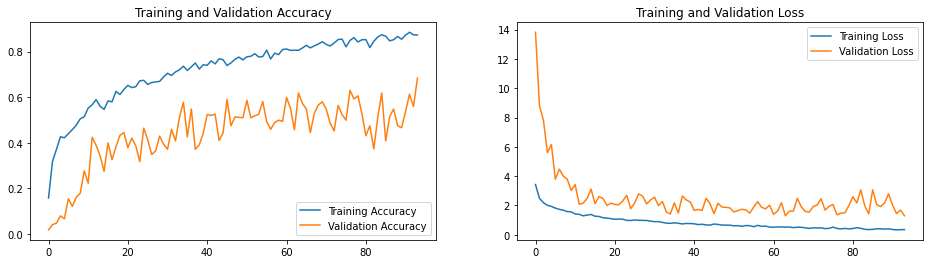

9/9 [==============================] - 8s 872ms/step - loss: 1.2904 - accuracy: 0.6778 - top-3 accuracy: 0.8722 - top-5 accuracy: 0.9475


In [ ]:
train_model(1)

Found 2285 validated image filenames belonging to 87 classes.
Found 571 validated image filenames belonging to 87 classes.
Epoch 1/125
36/36 [==============================] - ETA: 0s - loss: 3.4105 - accuracy: 0.1628 - top-3 accuracy: 0.3400 - top-5 accuracy: 0.4569
Epoch 1: val_accuracy improved from -inf to 0.04203, saving model to /content/drive/MyDrive/CustomResNet/saved_models/model_2.h5
36/36 [==============================] - 53s 1s/step - loss: 3.4105 - accuracy: 0.1628 - top-3 accuracy: 0.3400 - top-5 accuracy: 0.4569 - val_loss: 8.0632 - val_accuracy: 0.0420 - val_top-3 accuracy: 0.0858 - val_top-5 accuracy: 0.1103
Epoch 2/125
36/36 [==============================] - ETA: 0s - loss: 2.5262 - accuracy: 0.2915 - top-3 accuracy: 0.5457 - top-5 accuracy: 0.6862
Epoch 2: val_accuracy did not improve from 0.04203
36/36 [==============================] - 39s 1s/step - loss: 2.5262 - accuracy: 0.2915 - top-3 accuracy: 0.5457 - top-5 accuracy: 0.6862 - val_loss: 6.3408 - val_accuracy

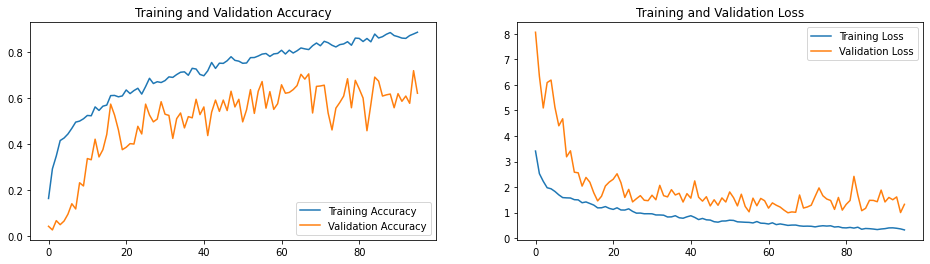

9/9 [==============================] - 8s 860ms/step - loss: 0.9959 - accuracy: 0.7163 - top-3 accuracy: 0.9159 - top-5 accuracy: 0.9632


In [ ]:
train_model(2)

Found 2285 validated image filenames belonging to 87 classes.
Found 571 validated image filenames belonging to 87 classes.
Epoch 1/125
36/36 [==============================] - ETA: 0s - loss: 3.3815 - accuracy: 0.1646 - top-3 accuracy: 0.3348 - top-5 accuracy: 0.4530
Epoch 1: val_accuracy improved from -inf to 0.02627, saving model to /content/drive/MyDrive/CustomResNet/saved_models/model_3.h5
36/36 [==============================] - 51s 1s/step - loss: 3.3815 - accuracy: 0.1646 - top-3 accuracy: 0.3348 - top-5 accuracy: 0.4530 - val_loss: 9.8168 - val_accuracy: 0.0263 - val_top-3 accuracy: 0.0771 - val_top-5 accuracy: 0.1068
Epoch 2/125
36/36 [==============================] - ETA: 0s - loss: 2.4898 - accuracy: 0.3103 - top-3 accuracy: 0.5641 - top-5 accuracy: 0.6928
Epoch 2: val_accuracy improved from 0.02627 to 0.03152, saving model to /content/drive/MyDrive/CustomResNet/saved_models/model_3.h5
36/36 [==============================] - 39s 1s/step - loss: 2.4898 - accuracy: 0.3103 - 

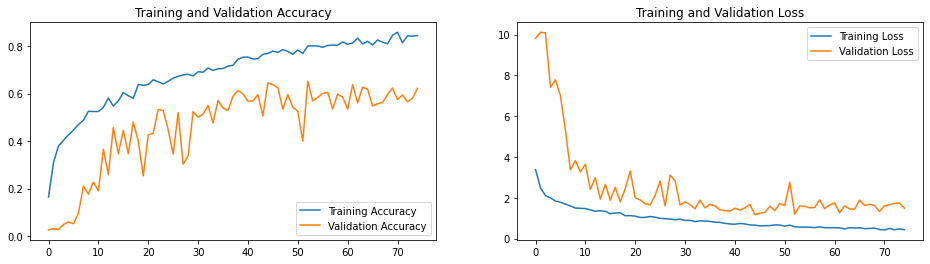

9/9 [==============================] - 8s 833ms/step - loss: 1.1817 - accuracy: 0.6637 - top-3 accuracy: 0.8739 - top-5 accuracy: 0.9405


In [ ]:
train_model(3)

Found 2285 validated image filenames belonging to 87 classes.
Found 571 validated image filenames belonging to 87 classes.
Epoch 1/125
36/36 [==============================] - ETA: 0s - loss: 3.3731 - accuracy: 0.1698 - top-3 accuracy: 0.3400 - top-5 accuracy: 0.4547
Epoch 1: val_accuracy improved from -inf to 0.01576, saving model to /content/drive/MyDrive/CustomResNet/saved_models/model_4.h5
36/36 [==============================] - 53s 1s/step - loss: 3.3731 - accuracy: 0.1698 - top-3 accuracy: 0.3400 - top-5 accuracy: 0.4547 - val_loss: 13.3418 - val_accuracy: 0.0158 - val_top-3 accuracy: 0.0718 - val_top-5 accuracy: 0.0928
Epoch 2/125
36/36 [==============================] - ETA: 0s - loss: 2.4148 - accuracy: 0.3063 - top-3 accuracy: 0.5961 - top-5 accuracy: 0.7344
Epoch 2: val_accuracy improved from 0.01576 to 0.03503, saving model to /content/drive/MyDrive/CustomResNet/saved_models/model_4.h5
36/36 [==============================] - 40s 1s/step - loss: 2.4148 - accuracy: 0.3063 -

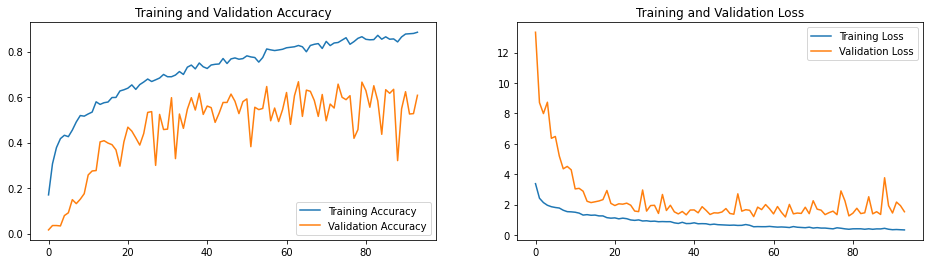

9/9 [==============================] - 8s 838ms/step - loss: 1.1641 - accuracy: 0.6637 - top-3 accuracy: 0.8809 - top-5 accuracy: 0.9457


In [ ]:
train_model(4)

In [ ]:
model = Custom_model(list(input_shape)+[3],87, 1.0)
	# COMPILE NEW MODEL
model.compile(
     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
     optimizer='adam',
    metrics=['accuracy',TopKCategoricalAccuracy(3, "top-3 accuracy"), TopKCategoricalAccuracy(5, "top-5 accuracy")])

In [ ]:
model.load_weights(save_dir+get_model_name(0))# load weights of model no.1
model.evaluate(test_set)

12/12 [==============================] - 12s 111ms/step - loss: 1.3765 - accuracy: 0.6006 - top-3 accuracy: 0.8567 - top-5 accuracy: 0.9449


[1.3765052556991577, 0.6005509495735168, 0.8567492961883545, 0.944903552532196]

In [ ]:
model.load_weights(save_dir+get_model_name(1))# load weights of model no.1
model.evaluate(test_set)

12/12 [==============================] - 1s 98ms/step - loss: 1.3883 - accuracy: 0.6639 - top-3 accuracy: 0.8540 - top-5 accuracy: 0.9256


[1.3883295059204102,
 0.6639118194580078,
 0.8539944887161255,
 0.9256198406219482]

In [ ]:
model.load_weights(save_dir+get_model_name(2))# load weights of model no.1
model.evaluate(test_set)

12/12 [==============================] - 1s 99ms/step - loss: 1.5195 - accuracy: 0.6198 - top-3 accuracy: 0.8512 - top-5 accuracy: 0.9284


[1.51952064037323, 0.6198347210884094, 0.8512396812438965, 0.9283746480941772]

In [ ]:
model.load_weights(save_dir+get_model_name(3))# load weights of model no.1
model.evaluate(test_set)

12/12 [==============================] - 1s 99ms/step - loss: 1.2906 - accuracy: 0.6281 - top-3 accuracy: 0.8650 - top-5 accuracy: 0.9256


[1.2906181812286377,
 0.6280992031097412,
 0.8650137782096863,
 0.9256198406219482]